# 課題7 主成分分析

In [22]:
import csv
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

## Q1 共分散行列
2つの変数x,yが取る対応する$n$個の値を

$x=x_1,x_2,...,x_n$, 

$y=y_1,y_2,...,y_n$

とすると、これらの変数間の共分散は以下のように計算できる。共分散は変数間の関係性を表すのに用いられ、共分散を正規化したものは相関係数となる。

$ \Sigma_{i=1}^{n} (x_i- \overline{x}) (y_i- \overline{y})/n$

$\overline{x}, \overline{y}$はそれぞれ$x$と$y$の平均。

不偏分散とする場合は$n-1$で割るが、本課題では標準分散を考え$n$で割ることを考える。

複数の変数について、変数間の分散（同一変数について）と共分散（異なる変数について）の一覧を行列の形でまとめたものを分散共分散行列と呼び（以下では単に共分散行列と呼ぶことにする）、2変数の場合は、共分散行列は以下のように表される。


$
   \left(
    \begin{array}{cc}
        \Sigma_{i=1}^{n}(x_i- \overline{x})^2/n  &  \Sigma_{i=1}^{n} (x_i- \overline{x}) (y_i- \overline{y})/n  \\
      \Sigma_{i=1}^{n} (x_i- \overline{x}) (y_i- \overline{y})/n　 &  \Sigma_{i=1}^{n}(y_i- \overline{y})^2/n 
    \end{array}
  \right)
$

行列（2次元配列）を引数として受け取り、***各列を変数として列間の***共分散行列を返す関数`cov_matrix`を完成させてください。

In [23]:
def cov_matrix(X):
    ### 引数：
    # X: 行列（2次元配列）
    
    ### 入力の行列の列間の共分散行列を計算するコード
    cov_matrix = np.cov(X.T)
    return cov_matrix

`cov_matrix`関数が完成したら、以下のセルを実行して動作を確認してください。課題6で用いたirisデータセットの4つの特徴量間の共分散行列を求めています。その共分散行列は以下のようになります。
```Python
[[ 0.68112222 -0.03900667  1.26519111  0.51345778]
 [-0.03900667  0.18675067 -0.319568   -0.11719467]
 [ 1.26519111 -0.319568    3.09242489  1.28774489]
 [ 0.51345778 -0.11719467  1.28774489  0.57853156]]
```

In [24]:
from sklearn.datasets import load_iris
iris = load_iris() 
X_iris=iris['data']
print(cov_matrix(X_iris))

[[ 0.68569351 -0.03926846  1.27368233  0.5169038 ]
 [-0.03926846  0.18800403 -0.32171275 -0.11798121]
 [ 1.27368233 -0.32171275  3.11317942  1.29638747]
 [ 0.5169038  -0.11798121  1.29638747  0.58241432]]


## Q2 主成分分析
以下では、主成分分析により特徴量の次元縮約を行う`pca`関数を実装します。`pca`関数では第1引数に入力のデータ行列（データ数($m$)$\times$次元数($n$))、第2引数に次元数$k$を受け取り、入力データを第2引数で指定された次元数に縮約した行列（データ数($m$)$\times$次元数($k$))とその時の累積寄与率を返します。

具体的に、`pca`関数では以下の手順により入力データの次元縮約を行います。

- 各次元（特徴量）の標準化

    - 入力データの各次元（特徴量）をそれぞれ平均0, 分散1に標準化する

- 特徴量間の共分散行列の作成

    - 標準化した特徴量間の共分散行列（$n \times n$)を作成する

- 共分散行列の固有値・固有ベクトルの計算

    - 固有値・固有ベクトルの計算には`NumPy`の`np.linalg.eig`関数を用いる。`np.linalg.eig`関数の引数に以下のように行列を与えると、その行列の固有値を要素とする配列`w`とそれらの固有値に対応する固有ベクトルを列に持つ行列`v`を返します。
```Python
w, v = np.linalg.eig(行列)
```
- 元のデータを$k$個の固有ベクトル（主成分）を基底とする座標で表す

    - 上記で計算した固有値・固有ベクトルについて、固有ベクトルをそれが対応する固有値の大きい順に$k$個選び、それらをデータの新たな基底とします。

        - 例えば、$n=4, k=2$ とし、4次元のデータを2次元に縮約するときは、固有値の大きい順に固有ベクトル$v_1, v_2$（それぞれ$1\times n$のベクトル）を２つ選び、元のデータ$x^{(i)}$（$n\times 1$のベクトル）との内積を計算することで、元のデータに対して$v_1, v_2$を新たな基底とする縮約された次元の座標$x^{(i)}_{new}$を計算できる。

        - $x^{(i)}_{new}=(x^{(i)}v_1, x^{(i)}v_2)$（$v_1, v_2$を基底とする座標）

    - 上記で標準化した元の入力データ行列を$X$（$x^{(1)},x^{(2)},...,x^{(m)}$を行ベクトルとする行列）とし、$k$個の固有ベクトル$v_1,v_2,...,v_k$を列ベクトルとする行列$(v_1 v_2 ... v_k)$を考えると、`pca`関数が返す$k$次元に縮約されたデータは$v_1,v_2,...,v_k$を基底した座標点として以下のように表せる。

    - $
    \left(
    \begin{array}{c}
      x^{(1)}_{new}  \\
       x^{(2)}_{new}  \\
        ...  \\
         x^{(m)}_{new}  \\
    \end{array}
  \right)
  =
  \left(
    \begin{array}{c}
      x^{(1)}  \\
       x^{(2)}  \\
        ...  \\
         x^{(m)}  \\
    \end{array}
  \right)
    \left(
    \begin{array}{cccc}
      v_1 & v_2 & ... & v_k 
    \end{array}
  \right)
  =
  \left(
    \begin{array}{c}
      x^{(1)} v_1,  x^{(1)} v_2, ..., x^{(1)} v_k \\
       x^{(2)} v_1,  x^{(2)} v_2, ..., x^{(2)} v_k \\
    ...  \\
     x^{(m)} v_1,  x^{(m)} v_2, ..., x^{(m)} v_k \\ 
    \end{array}
  \right)
$

- 累積寄与率の計算
    - $k$個の固有ベクトル（主成分）までの固有値$\lambda_i(i=1,..,k)$（分散）の和が全部の固有値（分散）$\lambda_i(i=1,..,n)$の総和に占める以下の割合を累積寄与率と呼ぶ。`pca`関数は$k$次元に縮約されたデータとともにこの累積寄与率を返す

    - $\Sigma_{i=1}^k\lambda_i/\Sigma_{i=1}^n\lambda_i$

上記に従って、`pca`関数を完成させてください。

In [61]:
def pca(X, k):
    ### 引数：
    # mat: 入力のデータ行列(データ数m*次元数n)
    # k: 次元数
    
    ### 1. 入力データの各列を標準化するコード
        # 分散は標準分散としてよい
        X_norm = scipy.stats.zscore(X.T)
    
    ### 2. 1.で標準化した入力データの列間の共分散行列を作成するコード
        # 分散、共分散は標準分散としてよい
        X_cov = np.cov(X_norm)
    
    ### 3. 共分散行列の固有値・固有ベクトルを計算するコード
        # w, v = np.linalg.eig(共分散行列)
        w, v = np.linalg.eig(X_cov)
            # 固有値の大きい順にk個の固有ベクトル（vの列ベクトル）は以下のように指定できる
        ind = np.argsort(w)[::-1] # 固有値の大きい順に並び替えた時のwのインデックス
        w_k = w[ind[:k]] # k個の固有値
        v_k = v[:, ind[:k]] # k個の固有ベクトル
    
    ### 4. 標準化した入力データをk個の固有ベクトルを基底とした座標で表した行列を求めるコード
        # 1.で標準化した入力データとv[:, ind[:k]]の積を考えるとよい
        matrix_pca = np.dot(X_norm.T, v_k)

    ### 5. 累積寄与率を計算するコード
        # 固有値を要素とする配列wを使う
        ccr = np.sum(w_k) / len(X_norm)
    
    ### 4.と5.の結果を返す
        return matrix_pca, ccr

`pca`関数が完成したら、以下のセルをそれぞれ実行して動作を確認してください。それぞれ、irisデータセットの4つの特徴量からなる特徴空間を1次元、2次元、3次元に次元縮約した結果を可視化しています。データは花の種類ごとに色分けしており、縮約された特徴空間において花の種類ごとにデータが近接していることがわかります。

1次元に縮約した時の累積寄与率は約0.72ですが、2次元に縮約した時の累積寄与率は約0.95となり、データ全体の分散に対して第1と第2の主成分（固有ベクトル）の分散（固有値）が多く占めていることがわかります。

0.14321374749947555


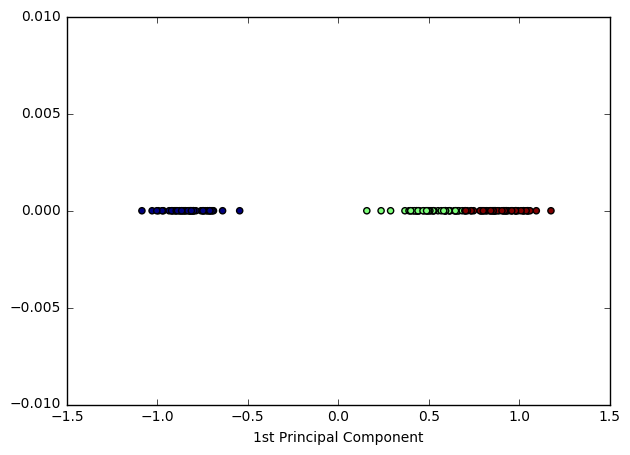

In [62]:
from sklearn.datasets import load_iris

iris = load_iris() 
X_iris=iris['data']
D, P=pca(X_iris, 1) # 1次元に縮約
print(P) # 累積寄与率

plt.figure(figsize=(7,5))
plt.xlabel("1st Principal Component")
plt.scatter(D[:,0], np.zeros(D.shape[0]),c=iris.target);

0.14571213583801956


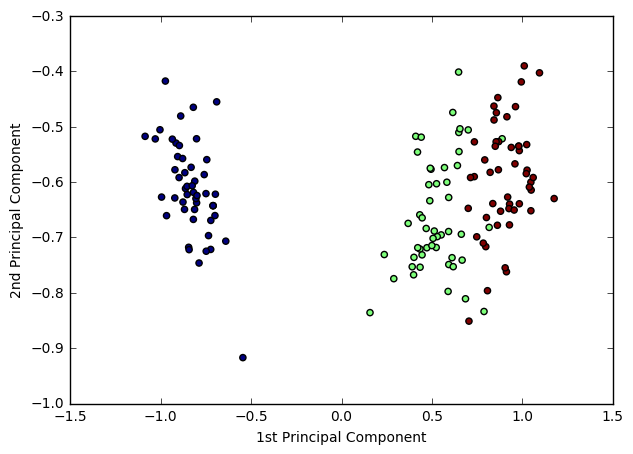

In [63]:
from sklearn.datasets import load_iris

iris = load_iris() 
X_iris=iris['data']
D, P=pca(X_iris, 2) # 2次元に縮約
print(P) # 累積寄与率

plt.figure(figsize=(7,5))
plt.xlabel("1st Principal Component")
plt.ylabel("2nd Principal Component")
plt.scatter(D[:,0], D[:,1],c=iris.target);

0.1471174227190527


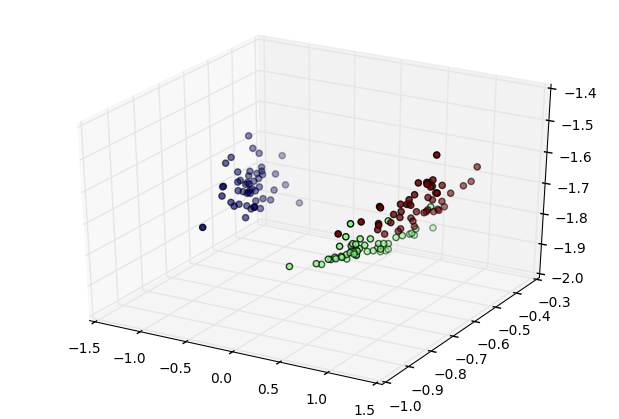

In [64]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import load_iris

iris = load_iris() 
X_iris=iris['data']
D, P=pca(X_iris, 3) # 3次元に縮約
print(P) # 累積寄与率

ax = Axes3D(plt.figure())
ax.scatter(D[:,0], D[:,1], D[:,2],c=iris.target);

## 参考：scikit-learnでの主成分分析

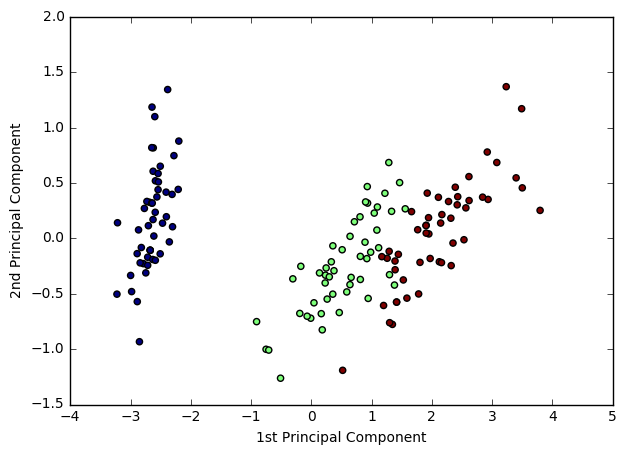

In [65]:
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

iris = load_iris() 
X_iris=iris['data']

# 以下では入力の標準化はしていない
model = PCA(n_components=2) 
model.fit(X_iris) 
D=model.transform(X_iris) 

plt.figure(figsize=(7,5))
plt.xlabel("1st Principal Component")
plt.ylabel("2nd Principal Component")
plt.scatter(D[:,0], D[:,1],c=iris.target);